# Filter snowlines using monthly median and IQR of full timeseries

In [7]:
##### MODIFY HERE #####
# path to snow-cover-mapping
base_path = '/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/'
# specify site name
site_name = 'Boulder'
# path where figures will be saved
figures_out_path = '/Users/raineyaberle/Google Drive/My Drive/Research/PhD/snow_cover_mapping/study-sites/' + site_name + '/figures/' 
# path to snowline files
sl_est_path = figures_out_path +'../imagery/snowlines/' 
# path where filtered snowlines will be saved
out_path = sl_est_path 
# path to USGS mass balance data/ELA csvs 
# If no USGS files, set usgs_path=None
usgs_path = None #'/Users/raineyaberle/Google Drive/My Drive/Research/PhD/GIS_data/USGS/benchmarkGlacier_massBalance/'
#######################

# import packages
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import glob
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy.stats import iqr
from time import mktime
import seaborn as sns
from scipy.stats import median_abs_deviation as mad

### Stack observations by month, filter points using the monthly distribution

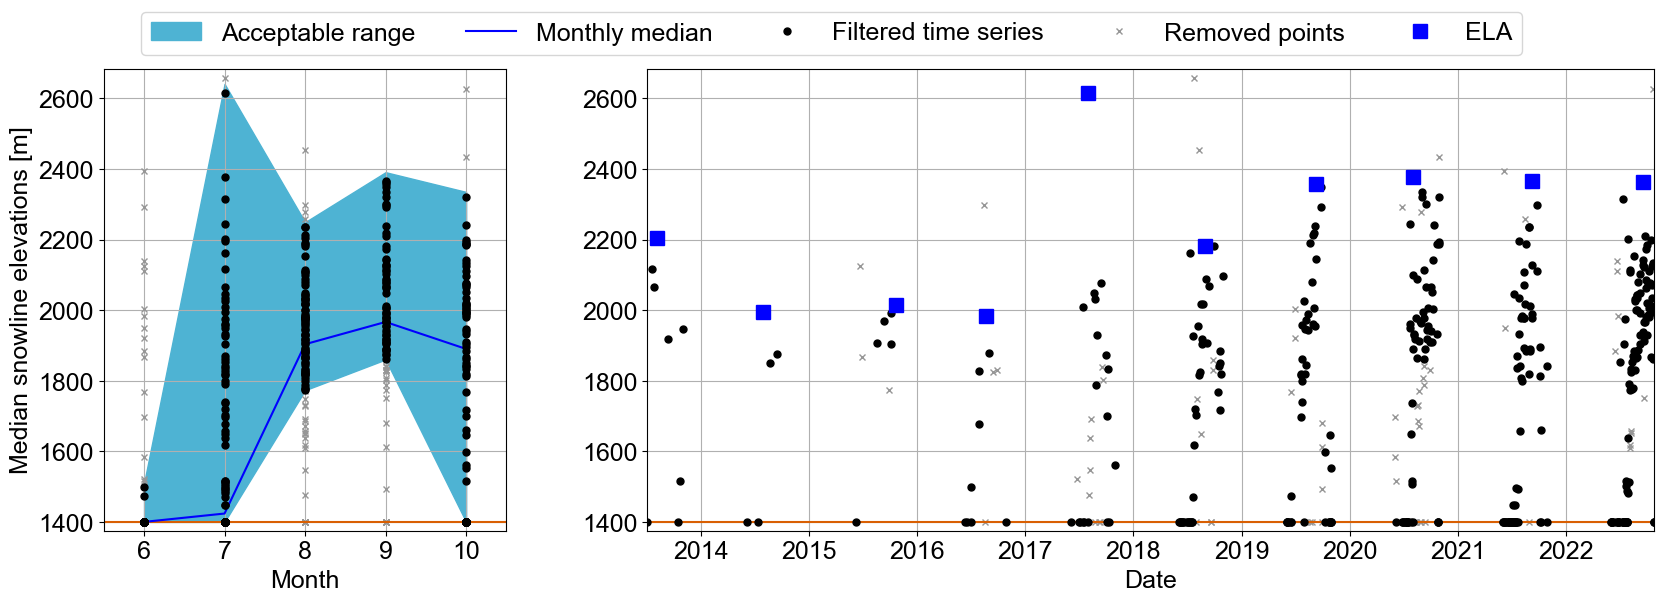

Number of removed points = 70
figure saved to file: /Users/raineyaberle/Google Drive/My Drive/Research/PhD/snow_cover_mapping/study-sites/Boulder/figures/20130703_20221024_Boulder_filtered_snowlines.png
filtered snowlines saved to file: /Users/raineyaberle/Google Drive/My Drive/Research/PhD/snow_cover_mapping/study-sites/Boulder/figures/../imagery/snowlines/20130703_20221024_Boulder_filtered_snowlines.csv
ELAs saved to file: /Users/raineyaberle/Google Drive/My Drive/Research/PhD/snow_cover_mapping/study-sites/Boulder/figures/../imagery/snowlines/20130703_20221024_Boulder_ELAs.csv
 


In [8]:
# -----Compile snowline files
sl_est_fns = glob.glob(sl_est_path + '*snowline.csv')
# compile all snowline files into one DataFrame
sl_est_full = pd.DataFrame()
for fn in sl_est_fns:
    # read file
    if 'csv' in fn:
        sl_est = pd.read_csv(fn)
    elif 'pkl' in fn:
        sl_est = pickle.load(open(fn, 'rb'))
    # concatenate to df
    sl_est_full = pd.concat([sl_est_full, sl_est])
sl_est_full = sl_est_full.reset_index(drop=True).sort_values(by=['datetime']) # renumber, sort by date

# -----Reformat snowlines dataframes
# unify datetime datatypes
sl_est_full['datetime'] = sl_est_full['datetime'].astype('datetime64[ns]')
# add month column
sl_est_full['month'] = [x.month for x in sl_est_full['datetime']]
# extract all unique months
months = np.unique(sl_est_full['month'])
# set datetime as index
sl_est_full.index = sl_est_full['datetime']

# ----Set up figure
fig = plt.figure(figsize=(20, 6))
plt.rcParams.update({'font.size':18, 'font.sans-serif':'Arial'})
spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=[1, 2.5])
ax1 = fig.add_subplot(spec[0, 0])
ax1.set_xlabel('Month')
ax1.set_ylabel('Median snowline elevations [m]')
ax1.grid()
ax2 = fig.add_subplot(spec[0, 1])
ax2.set_xlabel('Date')
ax2.grid()

# -----Filter points using median and IQR trend
med = np.array([np.nanmedian(sl_est_full.loc[sl_est_full['month']==month]['snowlines_elevs_median_m']) for month in months])
# mean = np.array([np.nanmean(sl_est_full.loc[sl_est_full['month']==month]['snowlines_elevs_median_m']) for month in months])
# std = np.array([np.nanstd(sl_est_full.loc[sl_est_full['month']==month]['snowlines_elevs_median_m']) for month in months])
# MAD = np.array([mad(sl_est_full.loc[sl_est_full['month']==month]['snowlines_elevs_median_m'], nan_policy='omit') for month in months])
IQR_min = np.array([iqr(sl_est_full.loc[sl_est_full['month']==month]['snowlines_elevs_median_m'],
                        rng=(25,50), nan_policy='omit') for month in months])
# if minimum goes below the glacier elevation range, make it the minimum elevation
IQR_min[IQR_min < np.nanmin(sl_est_full['snowlines_elevs_median_m'])]== np.nanmin(sl_est_full['snowlines_elevs_median_m'])
IQR_max = np.array([iqr(sl_est_full.loc[sl_est_full['month']==month]['snowlines_elevs_median_m'],
                        rng=(50,75), nan_policy='omit')*3 for month in months])
# if the IQR_max = IQR_min, increase the max value by 10% the elevation range
IQR_max[IQR_max==IQR_min] = (np.nanmax(sl_est_full['snowlines_elevs_median_m']) - np.nanmin(sl_est_full['snowlines_elevs_median_m']))*0.1

sl_est_full_filt = sl_est_full.copy() # filtered dataframe
n_filt = 0 # count number of filtered points
for j, month in enumerate(months):
    Ifilt = np.ravel(np.argwhere((sl_est_full.loc[sl_est_full['month']==month]['snowlines_elevs_median_m'] > med[j]+IQR_max[j]).values |
                    ((sl_est_full.loc[sl_est_full['month']==month]['snowlines_elevs_median_m'] < med[j]-IQR_min[j]).values)))
    n_filt = n_filt + len(Ifilt)
    if len(Ifilt)>0:
        sl_est_full_filt = sl_est_full_filt.mask((sl_est_full_filt['month']==month) & (sl_est_full_filt['snowlines_elevs_median_m'] > med[j]+IQR_max[j]))
        sl_est_full_filt = sl_est_full_filt.mask((sl_est_full_filt['month']==month) & (sl_est_full_filt['snowlines_elevs_median_m'] < med[j]-IQR_min[j]))

    # removed points
    ax1.plot(sl_est_full.loc[sl_est_full['month']==month].iloc[Ifilt]['month'],
             sl_est_full.loc[sl_est_full['month']==month].iloc[Ifilt]['snowlines_elevs_median_m'],
             'x', markersize=5, color='#969696', label='_nolegend_')
    ax2.plot(sl_est_full.loc[sl_est_full['month']==month].iloc[Ifilt]['datetime'],
             sl_est_full.loc[sl_est_full['month']==month].iloc[Ifilt]['snowlines_elevs_median_m'],
             'x', markersize=5, color='#969696')

# -----Determine annual ELAs
# add years column
sl_est_full_filt['year'] = [x.year for x in sl_est_full_filt['datetime']]
# grab all unique years
years = np.unique(sl_est_full_filt['year'].dropna())
# initialize dataframe for ELAs
ELAs_df = pd.DataFrame()
# loop through years, save maximum median snowline elevation and date of observation
for year in years:
    sl_est_year = sl_est_full_filt.loc[sl_est_full_filt['year']==year]
    ELA, dt = sl_est_year.loc[sl_est_year['snowlines_elevs_median_m']==np.max(sl_est_year['snowlines_elevs_median_m'])][['snowlines_elevs_median_m', 'datetime']].values[0]
    df = pd.DataFrame({'ELA_m': ELA,
                       'datetime':dt},
                      index=[0])
    ELAs_df = pd.concat([ELAs_df, df])
ELAs_df = ELAs_df.reset_index(drop=True)

# -----Plot
ax1.set_xlim(np.min(months)-0.5, np.max(months)+0.5)
ax2.set_xlim(np.nanmin(sl_est_full['datetime']), np.nanmax(sl_est_full['datetime']))
# plot minimum elevation
elev_min = np.nanmin(sl_est_full['snowlines_elevs_median_m'])
ax1.plot([ax1.get_xlim()[0], ax1.get_xlim()[1]],
         [elev_min, elev_min], '-', color='#d95f02', label='_nolegend_')
ax2.plot([ax2.get_xlim()[0], ax2.get_xlim()[1]],
         [elev_min, elev_min], '-', color='#d95f02', label='_nolegend_')
# range of acceptable values
ax1.fill_between(months, med-IQR_min, med+IQR_max, color='#4eb3d3', label='Acceptable range')
# monthly median
ax1.plot(months, med, '-b', label='Monthly median')
# filtered time series
ax1.plot(sl_est_full_filt['month'], sl_est_full_filt['snowlines_elevs_median_m'], '.k', markersize=10, label='Filtered time series')
ax2.plot(sl_est_full_filt['datetime'], sl_est_full_filt['snowlines_elevs_median_m'], '.k', markersize=10)
# ELAs
ax2.plot(ELAs_df['datetime'], ELAs_df['ELA_m'], 's', color='b', markersize=10)
# dummy points for legend
ax1.plot(0, 0, 'x', markersize=5, color='#969696', label='Removed points')
ax1.plot(0, 0,  's', color='b', markersize=10, label='ELA')
# optional: plot USGS ELA estimates
if usgs_path:
    usgs_fn = usgs_path + site_name+'/Output_'+site_name+'_Glacier_Wide_solutions_calibrated.csv'
    usgs_file = pd.read_csv(usgs_fn)
    ELA = usgs_file['ELA_m']
    ELA_date = usgs_file['Ba_Date'].astype(np.datetime64)
    ax1.plot(0,0, 's', markerfacecolor='None', markeredgecolor='orange',
             ms=10, markeredgewidth=2, label='USGS ELA')
    ax2.plot(ELA_date, ELA, 's', markerfacecolor='None', markeredgecolor='orange',
             ms=10, markeredgewidth=2, label='_nolegend_')
# set axis limits
ax1.set_xticks(np.linspace(months[0], months[-1], num=months[-1]-months[0]+1))
ax1.set_xlim(np.min(months)-0.5, np.max(months)+0.5)
ax2.set_xlim(np.nanmin(sl_est_full['datetime']), np.nanmax(sl_est_full['datetime']))
ymin, ymax = (np.nanmin(np.concatenate([sl_est_full['snowlines_elevs_median_m'].values, np.array(med-IQR_min)]))-25,
              np.nanmax(np.concatenate([sl_est_full['snowlines_elevs_median_m'].values, np.array(med+IQR_max)]))+25)
ax1.set_ylim(ymin, ymax)
ax2.set_ylim(ymin, ymax)
# add legend to figure
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=len(labels))

plt.show()
print('Number of removed points = '+str(n_filt))

# -----Save figure
min_date = str(np.nanmin(sl_est_full['datetime']))[0:10].replace('-','')
max_date = str(np.nanmax(sl_est_full['datetime']))[0:10].replace('-','')
fig_fn = figures_out_path + min_date + '_'+ max_date + '_' + site_name + '_filtered_snowlines.png'
fig.savefig(fig_fn, dpi=300, facecolor='w')
print('figure saved to file: ' + fig_fn)

# -----Save filtered snowline time series
sl_fn = min_date + '_' + max_date + '_' + site_name + '_filtered_snowlines.csv'
sl_est_full_filt = sl_est_full_filt.dropna().drop(['datetime', 'month'], axis=1)
sl_est_full_filt.to_csv(out_path + sl_fn)
print('filtered snowlines saved to file: ' + out_path + sl_fn)

# -----Save ELA times series
ELAs_fn = min_date + '_' + max_date + '_' + site_name + '_ELAs.csv'
ELAs_df.to_csv(out_path + ELAs_fn)
print('ELAs saved to file: ' + out_path + ELAs_fn)
print(' ')